In [1]:
import pandas as pd
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import statsmodels.api as sm

In [2]:
warnings.simplefilter(action='ignore', category=UserWarning)

___
PATHS
___

In [30]:
base_dir = '/rri_disks/eugenia/meltzer_lab/NROD98/wab_xtract'

behav_path = base_dir + '/behavioral/wab_scores.csv'
tract_path = base_dir + '/native_diffusion_space_output'

lesion_wab_path = base_dir + '/tables/wab_lesion_volume.csv'
roi_damage_path = base_dir + '/tables/roi_damage.csv'
streamline_wab_path = base_dir + '/tables/wab_streamline.csv'
FA_wab_path = base_dir + '/tables/wab_mean_FA.csv'

___
COLUMNS OF INTEREST
___

In [38]:
behav_cols = ['subj', 'wab_fluency', 'wab_av_comp', 'wab_rep', 'wab_obj_name', 'wab_aphasia_score']
track_list = ['af', 'ar', 'ifo', 'ilf', 'slf3', 'uf']
unused_track_list = ['atr', 'cbd', 'cbp', 'cbt', 'cst', 'fa', 'fx', 'mdlf','or', 'str', 'vof']
wab_list = ['wab_fluency', 'wab_av_comp', 'wab_rep', 'wab_obj_name', 'wab_aphasia_score']
roi_list = ['temporal', 'frontal', 'motor', 'parietal']
st_cols = ['subj'] + track_list

___
LOAD DATAFRAMES
___

In [40]:
behavDF = pd.read_csv(behav_path)[behav_cols].dropna()
lesion_wab_DF = pd.read_csv(lesion_wab_path)
roi_damage_DF = pd.read_csv(roi_damage_path).rename(columns={'pid': 'subj'})
streamline_wab_DF = pd.read_csv(streamline_wab_path)
FA_wab_DF = pd.read_csv(FA_wab_path).rename(columns={'pid': 'subj'})

In [41]:
subj_list = behavDF.subj.to_list()

___
**1. AIC (Akaike Information Criterion)**

**2. BIC (Bayesian Information Criterion)**

- Measures used in statistical modeling to compare the goodness of fit of different models. 
- They are used to balance the trade-off between model complexity and model performance.
___

In [42]:
volume_cols = ['nonzero_voxel_volume']
FA_cols = ['subj', 'af_FA', 'ar_FA', 'ifo_FA', 'ilf_FA', 'slf3_FA', 'uf_FA']
tract_cols = ['subj', 'af', 'ar', 'ifo', 'ilf', 'slf3', 'uf']
roi_cols = ['subj', 'motor', 'frontal', 'parietal', 'temporal']
wab_cols = ['subj', 'wab_fluency', 'wab_av_comp', 'wab_rep', 'wab_obj_name', 'wab_aphasia_score']

all_cols = ['subj']
for item in tract_cols + FA_cols + roi_cols + wab_cols:
    if item != 'subj':
        all_cols.append(item)

In [48]:
FA_wab_DF = FA_wab_DF.rename(columns={'subj': 'subj', 'af': 'af_FA', 'ar': 'ar_FA', 'ifo': 'ifo_FA', 'ilf': 'ilf_FA', 'slf3': 'slf3_FA', 'uf': 'uf_FA' })
wab_roi_damage = pd.merge(roi_damage_DF, behavDF, on=["subj"])

___
MERGE DATAFRAMES FOR MULTIPLE REGRESSION
___

In [51]:
mergedDF = pd.merge(FA_wab_DF[FA_cols], lesion_wab_DF, on=["subj"])
mergedDF = pd.merge(mergedDF, streamline_wab_DF[tract_cols], on=["subj"])
mergedDF = pd.merge(mergedDF, wab_roi_damage[roi_cols], on=["subj"])[all_cols]
print("Number of participants:", len(mergedDF))
mergedDF.head()

Number of participants: 17


,subj,af,ar,ifo,ilf,slf3,uf,af_FA,ar_FA,ifo_FA,...,uf_FA,motor,frontal,parietal,temporal,wab_fluency,wab_av_comp,wab_rep,wab_obj_name,wab_aphasia_score
0,9336,247276.0,0.0,2429.0,37209.0,-181.0,609.0,-0.022067,0.000000,-0.014213,...,0.010083,0.0056,0.0152,0.0138,0.1566,5.0,8.0,7.5,9.5,78.30
1,9772,77231.0,7.0,43863.0,26490.0,6525.0,1789.0,-0.005771,0.089314,-0.042084,...,0.016661,0.0000,0.0000,0.0000,0.0000,10.0,10.0,10.0,10.0,96.70
2,10634,171200.0,-246.0,5313.0,-31324.0,4567.0,-1275.0,-0.005770,0.080112,0.014095,...,-0.005319,0.0000,0.0000,0.0660,0.2378,8.0,10.0,7.5,7.5,80.00
3,10651,373839.0,17.0,36787.0,6133.0,2807.0,8588.0,0.004550,0.021255,-0.024872,...,0.061578,0.0088,0.0372,0.1590,0.2590,8.0,9.0,7.5,10.0,90.83
4,10827,85974.0,16.0,1629.0,-6877.0,-2553.0,-3173.0,0.001997,-0.017290,0.003160,...,0.007116,0.0617,0.0022,0.3085,0.0002,8.0,10.0,9.5,10.0,95.80


___
DEFINE RELEVANT FUNCTIONS
___

In [52]:
def permutations(arr):
    if len(arr) == 0:
        return [[]]
    
    all_perms = []
    for i in range(len(arr)):
        first = arr[i]
        rest = arr[:i] + arr[i+1:]
        for perm in permutations(rest):
            all_perms.append([first] + perm)
    return all_perms

In [53]:
from tqdm import tqdm
def forward_selection(DF, predictors, target):
    # Define the dependent variable
    y = DF[target]

    # Initialize an empty list to store the selected predictors
    selected_predictors = []

    # Initialize the best AIC and BIC values
    best_aic = float('inf')
    best_bic = float('inf')
    best_rsquared = float('-inf')
    best_summary = ''

    # visited = ['slf2']
    # Loop through each predictor
    for predictor in predictors:

        # Fit a model with the current predictor and the selected predictors
        model = sm.OLS(y, DF[selected_predictors + [predictor]])
        result = model.fit()
        # print("r-squared: ", result.rsquared, "current-predictors: ", selected_predictors, "|| predictor:", predictor)
        
        # Calculate the AIC and BIC for the current model
        aic = result.aic
        bic = result.bic
        rsquared = result.rsquared
        
        # Check if the current model has a lower AIC or BIC value than the best model so far
        if (aic < best_aic or bic < best_bic) and rsquared > best_rsquared:
            # Update the best AIC and BIC values
            best_aic = aic
            best_bic = bic
            best_rsquared = rsquared
            best_summary = result.summary()
            
            # Add the current predictor to the list of selected predictors
            selected_predictors.append(predictor)
    
    # Print the selected predictors, AIC, and BIC values
    return best_aic, best_bic, best_rsquared, selected_predictors, best_summary

In [54]:
def get_best_predictors(DF, predictors, target):
    predictors_set_list =  permutations(predictors)
    best_aic = float('inf')
    best_bic = float('inf')
    best_rsquared = float('-inf')
    best_selected_predictors = []
    best_summary = ''
    for predictor_list in tqdm(predictors_set_list):
        aic, bic, rsquared, selected_predictors, summary= forward_selection(DF, predictor_list, target)
        if (aic < best_aic or bic < best_bic) and rsquared > best_rsquared:
            best_aic = aic
            best_bic = bic
            best_rsquared = rsquared
            best_selected_predictors = selected_predictors
            best_summary = summary
    print(target, best_aic, best_bic, best_rsquared, best_selected_predictors, best_summary)


___
MULTIPLE REGRESSION
___

In [55]:
wab_cols = ['wab_fluency', 'wab_av_comp', 'wab_rep', 'wab_obj_name', 'wab_aphasia_score']
tract_cols = ['af', 'ar', 'ifo', 'ilf', 'slf3', 'uf']
FA_cols = ['af_FA', 'ar_FA', 'ifo_FA', 'ilf_FA', 'slf3_FA', 'uf_FA']
roi_cols = ['motor', 'frontal', 'parietal', 'temporal']

In [56]:
for wab_measure in wab_cols:
    get_best_predictors(mergedDF, tract_cols, wab_measure)

  0%|          | 3/720 [00:00<00:34, 21.05it/s]

wab_fluency 107.56930014265211 109.23572683076455 0.48372282493831353 ['af', 'ifo']                                  OLS Regression Results                                
Dep. Variable:            wab_fluency   R-squared (uncentered):                   0.484
Model:                            OLS   Adj. R-squared (uncentered):              0.415
Method:                 Least Squares   F-statistic:                              7.027
Date:                Sat, 04 May 2024   Prob (F-statistic):                     0.00702
Time:                        17:51:52   Log-Likelihood:                         -51.785
No. Observations:                  17   AIC:                                      107.6
Df Residuals:                      15   BIC:                                      109.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err    

  1%|          | 6/720 [00:00<00:13, 52.32it/s]

wab_av_comp 110.31241794961677 111.97884463772921 0.6462753450154248 ['af', 'ifo']                                  OLS Regression Results                                
Dep. Variable:            wab_av_comp   R-squared (uncentered):                   0.646
Model:                            OLS   Adj. R-squared (uncentered):              0.599
Method:                 Least Squares   F-statistic:                              13.70
Date:                Sat, 04 May 2024   Prob (F-statistic):                    0.000412
Time:                        17:52:14   Log-Likelihood:                         -53.156
No. Observations:                  17   AIC:                                      110.3
Df Residuals:                      15   BIC:                                      112.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err     

  0%|          | 2/720 [00:00<00:38, 18.59it/s]

wab_rep 108.84999429136819 110.51642097948063 0.5735586712659139 ['af', 'ifo']                                  OLS Regression Results                                
Dep. Variable:                wab_rep   R-squared (uncentered):                   0.574
Model:                            OLS   Adj. R-squared (uncentered):              0.517
Method:                 Least Squares   F-statistic:                              10.09
Date:                Sat, 04 May 2024   Prob (F-statistic):                     0.00167
Time:                        17:52:36   Log-Likelihood:                         -52.425
No. Observations:                  17   AIC:                                      108.8
Df Residuals:                      15   BIC:                                      110.5
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err         

  0%|          | 3/720 [00:00<00:28, 24.74it/s]

wab_obj_name 112.52445519004935 115.024095222218 0.6399283665644804 ['af', 'ifo', 'ilf']                                  OLS Regression Results                                
Dep. Variable:           wab_obj_name   R-squared (uncentered):                   0.640
Model:                            OLS   Adj. R-squared (uncentered):              0.563
Method:                 Least Squares   F-statistic:                              8.294
Date:                Sat, 04 May 2024   Prob (F-statistic):                     0.00204
Time:                        17:52:59   Log-Likelihood:                         -53.262
No. Observations:                  17   AIC:                                      112.5
Df Residuals:                      14   BIC:                                      115.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std er

100%|██████████| 720/720 [00:20<00:00, 35.58it/s]

wab_aphasia_score 188.1618287912398 189.82825547935224 0.5600757972521411 ['af', 'ifo']                                  OLS Regression Results                                
Dep. Variable:      wab_aphasia_score   R-squared (uncentered):                   0.560
Model:                            OLS   Adj. R-squared (uncentered):              0.501
Method:                 Least Squares   F-statistic:                              9.548
Date:                Sat, 04 May 2024   Prob (F-statistic):                     0.00212
Time:                        17:53:25   Log-Likelihood:                         -92.081
No. Observations:                  17   AIC:                                      188.2
Df Residuals:                      15   BIC:                                      189.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err

In [ ]:
for wab_measure in wab_cols:
    get_best_predictors(mergedDF, FA_cols, wab_measure)

In [ ]:
for wab_measure in wab_cols:
    get_best_predictors(mergedDF, roi_cols, wab_measure)

___
GET BEST PREDICTORS ACROSS ALL THREE DAMAGE MEASURES
___

In [ ]:
predictors = ['slf3', 'uf', 'af', 'ifo', 'af_FA', 'ar_FA', 'slf3_FA', 'ilf_FA']

for wab_measure in wab_cols:
    get_best_predictors(mergedDF, predictors, wab_measure)

In [ ]:
predictors = ['motor', 'frontal', 'parietal', 'slf3', 'uf', 'af', 'ifo',]
for wab_measure in wab_cols:
    get_best_predictors(mergedDF, predictors, wab_measure)

In [ ]:
predictors = ['frontal', 'motor', 'parietal', 'slf3', 'af', 'uf', 'ifo', 'af_FA', 'ilf_FA', 'slf3_FA']
for wab_measure in wab_cols:
    get_best_predictors(mergedDF, predictors, wab_measure)

___
CHECK COLLINEARITY OF INDEPENDENT VARIABLES
___

Text(0, 0.5, 'Columns')

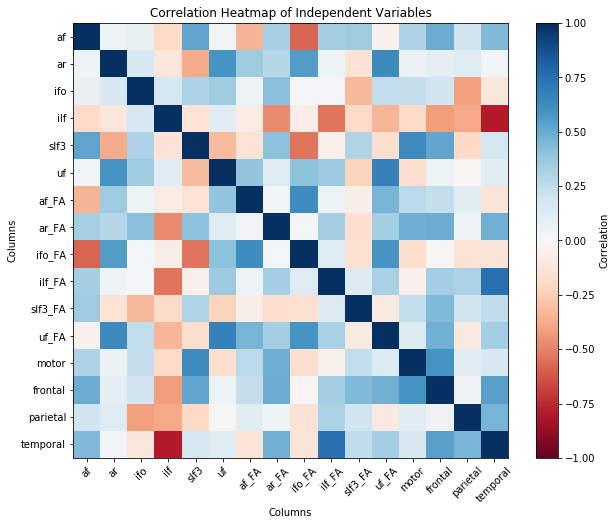

In [57]:
# Calculate correlation matrix
correlation_matrix = mergedDF[tract_cols + FA_cols + roi_cols].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')

# Set ticks
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns)

# Set title and labels
plt.title('Correlation Heatmap of Independent Variables')
plt.xlabel('Columns')
plt.ylabel('Columns')

# Show plot